## Assignment 5
-----

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import odeint
import chaospy as cp
#from scipy.special import hermite       # not the correct weight function needs rescaling

### Functions / Classes
------

In [2]:
def Hermite(n, x):
    """
    Recurrence relation for probabilistic hermite polynomial
    """
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return x*Hermite(n-1,x)-(n-1)*Hermite(n-2,x)

def Hermite_norm(n):
    """
    Norm of n-th hermite polynomial
    """
    return np.math.factorial(n)

def Hermite_triple_Exp(n, m, k):
    """
    Result of the triple expectation for hermite polynomials of degrees n,m,k
    Page 70 of book -> if condition not satisfied expectation = 0 instead
    """ 
    s = (n + m + k)/2

    if np.floor(s) == s and s >= max([n,m,k]):
        
        prod_norms = np.math.factorial(n)*np.math.factorial(m)*np.math.factorial(k)
        enum = np.math.factorial(s-n)*np.math.factorial(s-m)*np.math.factorial(s-k)

        return prod_norms/enum

    else:
        return 0

def ODE_int(init_val, delta_t, t_lim, alpha):
    # simple euler scheme asumes equidistant points
    sol = [init_val]
    t = 0
    while t < t_lim - 0.5*delta_t:
        new_val = sol[-1] + delta_t*(-1/2*sol[-1]**2+alpha*sol[-1])
        sol.append(new_val)
        t += delta_t
        
    return sol

def Galerkin(N, delta_t, t_lim):

    triple_exps = {}

    init_values = [[0] for i in range(N+1)]
    init_values[0] = [1/10]
   
    # gPC coeffs for alpha
    alpha = [0 for i in range(N+1)]
    alpha[0], alpha[1] = 1, 1

    # set init_vals
    sol = init_values
    t = 0
    while t < t_lim -0.5*delta_t:
        temp_sol =  [0 for i in range(N+1)]
        for k in range(N+1):
            for j in range(N+1):
                for i in range(N+1):

                    if triple_exps.get((i,j,k), -1) == -1:
                        triple_exps[(i,j,k)] = Hermite_triple_Exp(i,j,k)
                    e_ijk = triple_exps[(i,j,k)]

                    temp_sol[k] += (alpha[i]*sol[j][-1] -0.5*(sol[i][-1]*sol[j][-1]))*e_ijk/Hermite_norm(k)

        for ki, change in enumerate(temp_sol):
   
            sol[ki].append(sol[ki][-1] + delta_t*change)

        t += delta_t
    return sol


### Main
----

In [3]:
# Set parameters for the system
N = 100
t_vals = np.linspace(0, 2, N)
Z = np.random.standard_normal()


##### CALCUALTE APPROX ######
res = Galerkin(5, 2/(N-1), 2)

approx = [0 for i in range(len(res[0]))]

for n,coeffs in enumerate(res):
    for i, val in enumerate(coeffs):
        approx[i] += val*Hermite(n, Z)

##### CALCULATE REAL SOLUTION #####
alpha = 1 + Z

true_sol = ODE_int(1/10, 2/(N-1), 2, alpha)

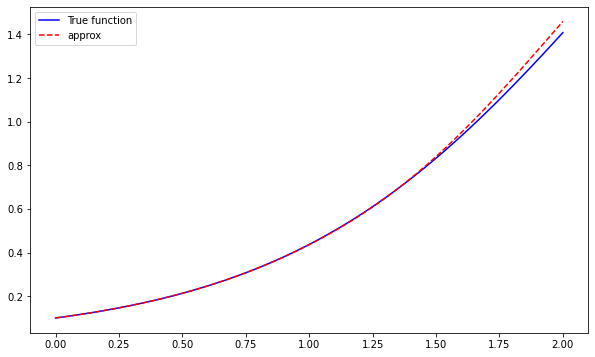

In [4]:
plt.figure(figsize=(10,6))
plt.plot(t_vals, true_sol, 'b-', label='True function');
plt.plot(t_vals, approx, 'r--', label='approx');

plt.legend();

### Expectation/Variance
-----

Monte-Carlo estimates at t = 2 using 10000 samples:
Mean : 1.1231237086692147
Variance : 1.8754122203846477

Stochastic Galerkin method estimates:
Mean : 1.1277362668648427
Variance : 1.9288182355578716


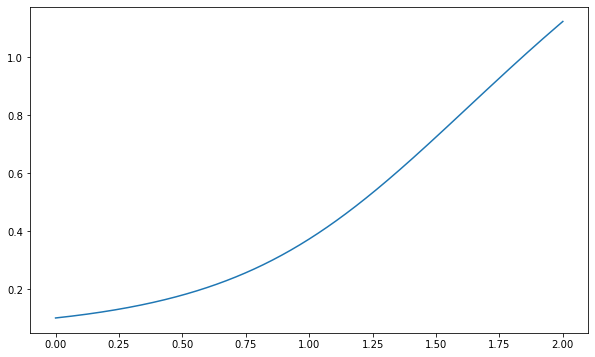

In [5]:
# number of samples
M = 10000
N = 1000

total_sol = np.zeros(N)
var = []

rand = np.random.standard_normal(M)
for i in range(M):
    alpha = 1 + rand[i]
    true_sol = np.array(ODE_int(1/10, 2/(N-1), 2, alpha))
    total_sol += true_sol
    var.append(true_sol[-1])
total_sol = total_sol/M

# plot mean solution as a function of t
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0, 2, N), total_sol);

##### PRINTS ######
O = 5
res = Galerkin(O, 2/(N-1), 2)

# Galerkin variance
var_G = 0
for i in range(O):
    if i == 0:
        continue
    var_G += Hermite_norm(i)*res[i][-1]**2

# print mean for t= 2
print(f'Monte-Carlo estimates at t = 2 using {M} samples:')
print(f'Mean : {total_sol[-1]}')
print(f'Variance : {np.var(var)}')
# Galerkin approach estimates:
print()
print('Stochastic Galerkin method estimates:')
print(f'Mean : {res[0][-1]}')
print(f'Variance : {var_G}')

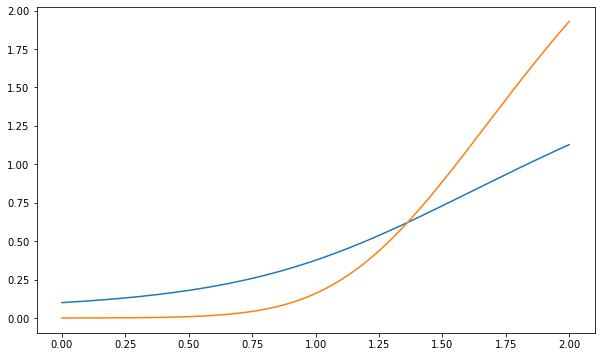

In [6]:
means = [res[0][i] for i in range(N)]

# variances
vars = []
for t in range(N):
    var_G = 0
    for i in range(O):
        if i == 0:
            continue
        var_G += Hermite_norm(i)*res[i][t]**2
    vars.append(var_G)

plt.figure(figsize=(10,6))
plt.plot(np.linspace(0, 2, N), means);
plt.plot(np.linspace(0, 2, N), vars);

### Test if polynomials are correct
----

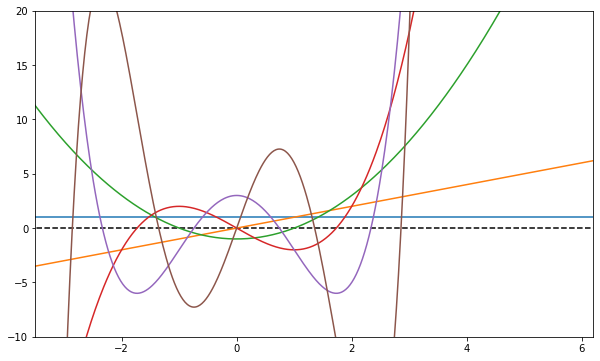

In [8]:
x = np.linspace(-4, 7, 600)
plt.figure(figsize=(10,6))
plt.hlines(0, -5, 7, color='black', ls='--')
plt.xlim(-3.5, 6.2)
plt.ylim(-10, 20)

for n in range(6):
    y_p =  [Hermite(n,z) for z in x]

    plt.plot(x,y_p);